In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.2-bin-hadoop2.7/
spark-3.0.2-bin-hadoop2.7/R/
spark-3.0.2-bin-hadoop2.7/R/lib/
spark-3.0.2-bin-hadoop2.7/R/lib/sparkr.zip
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/shell.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/general.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/index.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.0.2-

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [3]:
#1.	Load Data from CSV to Spark
spark.read.csv("Customer.csv",header=True).createOrReplaceTempView("customer")
spark.read.csv("Pet.csv",header=True).createOrReplaceTempView("pet")
spark.read.csv("Product.csv",header=True).createOrReplaceTempView("product")
spark.read.csv("ProductType.csv",header=True).createOrReplaceTempView("producttype")
spark.read.csv("TransactionDetail.csv",header=True).createOrReplaceTempView("trdetail")
spark.read.csv("TransactionHeader.csv",header=True).createOrReplaceTempView("trheader")

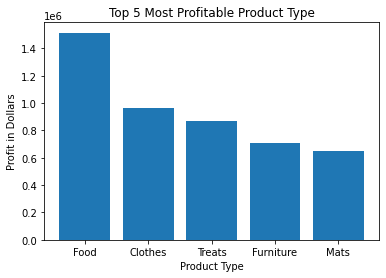

In [43]:
#2.	Query Analysis and Visualization
#a.	Show top 5 most profitable product type where the product price must be higher than 10 using bar plot.
data = spark.sql("""
  SELECT
  pt.ProductTypeName,
  SUM(td.Quantity*p.ProductPrice) AS Profit
  FROM
    producttype pt JOIN product p ON pt.ProductTypeId = p.ProductTypeId
    JOIN trdetail td ON p.ProductId = td.ProductId
  WHERE p.ProductPrice > 10
  GROUP BY pt.ProductTypeName
  ORDER BY Profit DESC
  LIMIT 5
""").toPandas()

plt.bar(data["ProductTypeName"], data["Profit"])
plt.title("Top 5 Most Profitable Product Type")
plt.xlabel("Product Type")
plt.ylabel("Profit in Dollars")
plt.show()

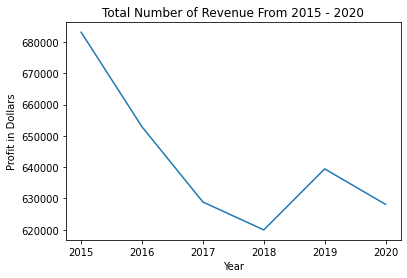

In [44]:
#b.	Show the total number of revenue per year from 2015 until 2020 using line plot.
data = spark.sql("""
  SELECT
    YEAR(th.TransactionDate) as year,
    SUM(td.Quantity*p.ProductPrice) as revenue
  FROM
  trheader th join trdetail td on th.TransactionId = td.TransactionId
  join product p on p.ProductId = td.ProductId
  WHERE YEAR(th.TransactionDate) between 2015 and 2020
  GROUP BY YEAR(th.TransactionDate)
  ORDER BY YEAR(th.TransactionDate) ASC 
""").toPandas()

plt.plot(data["year"],data["revenue"])
plt.xlabel("Year")
plt.ylabel("Profit in Dollars")
plt.title("Total Number of Revenue From 2015 - 2020")
plt.show()

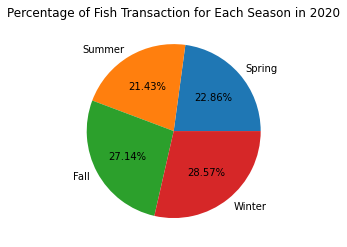

In [45]:
# c.	Show the percentage of fish product transaction for each season in 2020 in which the cost of the transaction is higher than 500 using pie plot. Below is the table explaining the seasons:
# Season	Months
# Spring	January, February, March
# Summer	April, May, June
# Fall	July, August, September
# Winter	October, November, December

data = spark.sql("""
  SELECT 
  Season,
  COUNT(TransactionId) AS totaltransaction
  FROM
  (
      SELECT
      th.TransactionId,
      MONTH(th.TransactionDate) as month,
      CASE
        WHEN MONTH(th.TransactionDate) BETWEEN 1 AND 3 THEN 'Spring'
        WHEN MONTH(th.TransactionDate) BETWEEN 4 AND 6 THEN 'Summer'
        WHEN MONTH(th.TransactionDate) BETWEEN 7 AND 9 THEN 'Fall'
        WHEN MONTH(th.TransactionDate) BETWEEN 10 AND 12 THEN 'Winter'
      END AS Season,
      SUM(td.Quantity*p.ProductPrice) as total
    FROM
      trheader th join trdetail td on th.TransactionId = td.TransactionId
      join product p on td.ProductId = p.ProductId
      join pet on pet.PetId = p.PetId
    WHERE pet.PetName = 'Fish' and YEAR(th.TransactionDate)=2020
    GROUP BY th.TransactionId, MONTH(th.TransactionDate)
    HAVING SUM(td.Quantity*p.ProductPrice) > 500
  )
  GROUP BY Season
""").toPandas()

plt.pie(data["totaltransaction"], labels=data["Season"], autopct="%.2f%%")
plt.title("Percentage of Fish Transaction for Each Season in 2020")
plt.show()



In [41]:
#Classification

from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#LoadData

train_data = spark.read.option("inferSchema","true").csv("IncomeEvaluationTraining.csv", header=True)
test_data = spark.read.option("inferSchema","true").csv("IncomeEvaluationTesting.csv", header=True)

#SelectFeatures

train_data = train_data.select("Education", "Occupation", "Hours-Per-Week", "Income")
test_data = test_data.select("Education", "Occupation", "Hours-Per-Week", "Income")

#DataPreprocessing

train_data = train_data.na.drop()
test_data = test_data.na.drop()

#TransformData

train_data = train_data.withColumn("Occupation", 
                                   when(train_data["Occupation"] == "Prof-specialty", 0).
                                   when(train_data["Occupation"] == "Adm-clerical", 1).
                                   when(train_data["Occupation"] == "Other-service", 2).
                                   when(train_data["Occupation"] == "Sales", 3).
                                   when(train_data["Occupation"] == "Tech-support", 4).
                                   otherwise(5)
                                   )
train_data = train_data.withColumn("Income", 
                                   when(train_data["Income"] == "<=50K", 0).otherwise(1)
                                   )

test_data = test_data.withColumn("Occupation", 
                                   when(test_data["Occupation"] == "Prof-specialty", 0).
                                   when(test_data["Occupation"] == "Adm-clerical", 1).
                                   when(test_data["Occupation"] == "Other-service", 2).
                                   when(test_data["Occupation"] == "Sales", 3).
                                   when(test_data["Occupation"] == "Tech-support", 4).
                                   otherwise(5)
                                   )
test_data = test_data.withColumn("Income", 
                                   when(test_data["Income"] == "<=50K", 0).otherwise(1)
                                   )

cols = train_data.columns
cols.remove("Income")
train_data = VectorAssembler(inputCols = cols, outputCol = "Features").transform(train_data)

scaler = StandardScaler(inputCol = "Features", outputCol = "Scaled_Features")
train_data = scaler.fit(train_data).transform(train_data)

cols = test_data.columns
cols.remove("Income")
test_data = VectorAssembler(inputCols = cols, outputCol = "Features").transform(test_data)

scaler = StandardScaler(inputCol = "Features", outputCol = "Scaled_Features")
test_data = scaler.fit(test_data).transform(test_data)

#GenerateModel
model = LogisticRegression(featuresCol = "Scaled_Features", labelCol = "Income", maxIter = 10).fit(train_data)

#ModelTesting
prediction = model.transform(test_data)

#Evaluation
evaluator = BinaryClassificationEvaluator(labelCol = "Income")
print("Accuracy : {}".format(evaluator.evaluate(prediction) * 100))


Accuracy : 78.15468682559671
